In [2]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

from huggingface_hub import login


#Code to login to Hugging Face with your token
from huggingface_hub import login
login()


import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from transformers import AutoImageProcessor, AutoModel, DefaultDataCollator
import pandas as pd
from scipy.ndimage import gaussian_filter

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance

# Check if LaTeX is installed and available
try:
    plt.rc('text', usetex=True)
    # You can also specify the font family to match your LaTeX document
    plt.rc('font', family='serif')
    # A common font family is Computer Modern, which is the default for LaTeX.
    plt.rc('font', serif='Computer Modern')
except RuntimeError:
    print("Warning: LaTeX is not installed. Using default Matplotlib fonts.")
    # Fallback to a non-LaTeX font if an error occurs
    plt.rc('font', family='serif')
    plt.rc('font', serif='DejaVu Serif')


In [2]:
def load_model_and_preprocessor(model_id):
    """
    Load a Hugging Face model and image processor with device selection.
    
    Device selection priority:
    1. CUDA (NVIDIA GPU)
    2. MPS (Apple Silicon GPU)
    3. CPU (fallback)
    
    Returns:
        model: loaded model on the selected device
        device: device string used ('cuda', 'mps', or 'cpu')
        preprocessor: loaded image processor
    """
    if torch.cuda.is_available():
        device = 'cuda'
    elif torch.backends.mps.is_available():
        device = 'mps'
    else:
        device = 'cpu'

    try:
        model = AutoModel.from_pretrained(model_id,  output_attentions=True,
    attn_implementation="eager")
        preprocessor = AutoImageProcessor.from_pretrained(model_id, use_fast=True)
        model = model.to(device)
        print(f"Model and preprocessor loaded successfully on device: {device}")
    except Exception as e:
        raise ValueError(f"Could not load Hugging Face model or preprocessor for '{model_id}': {e}")
    
    model.eval()
    return model, device, preprocessor

In [3]:
model_id = "facebook/dinov3-vitl16-pretrain-lvd1689m"

model, device, preprocessor = load_model_and_preprocessor(model_id=model_id)


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Model and preprocessor loaded successfully on device: mps


/var/folders/jz/0gg19x2n28n615n9r6mnsn1w0000gp/T/ipykernel_68486/2141503888.py:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  Image.fromarray((att_map_smooth * 255).astype(np.uint8)).resize(image.size, resample=Image.BILINEAR)


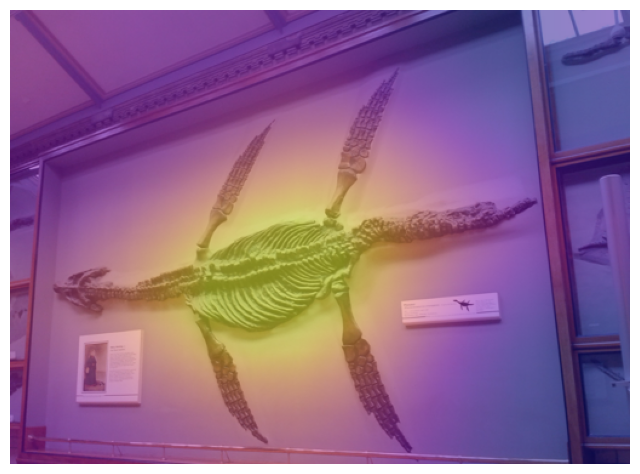

In [4]:


def get_register_attention_map_smooth(image_path, model, device, preprocessor, 
                                      register_count=4, layer=-1):
    """
    Extract a smoothed attention map from the register tokens of a DINOv3 model.
    Combines median aggregation, Gaussian smoothing, and percentile clipping.
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = preprocessor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)

    # attentions: tuple(num_layers)[batch, num_heads, num_tokens, num_tokens]
    attentions = outputs.attentions[layer][0]  # first (and only) batch
    num_heads = attentions.shape[0]
    num_tokens = attentions.shape[-1]

    # Tokens are ordered as: [CLS], [register tokens], [patch tokens]
    
    
    # Extract register → patch attention
    register_att = attentions[:, 1:1+register_count, 1+register_count:]  # [heads, regs, patches]

    # Median aggregation over heads and registers to reduce outliers/spikes
    att_map = np.median(register_att.cpu().numpy(), axis=(0,1))  # [patches]

    # Reshape back to spatial grid
    h = w = int(att_map.shape[0] ** 0.5)
    att_map = att_map.reshape(h, w)

    return att_map, image

def visualize_attention_smooth(image, att_map, blur_sigma=2.0, clip_percentile=(5, 95),
                               alpha=0.5, cmap='plasma'):
    """
    Overlay a smoothed attention map on the original image.
    
    Args:
        blur_sigma: Gaussian smoothing sigma in patch units (increase to reduce spikes)
        clip_percentile: tuple of low/high percentiles for clipping extreme values
        alpha: overlay transparency
        cmap: matplotlib colormap
    """
    # Apply Gaussian smoothing
    att_map_smooth = gaussian_filter(att_map, sigma=blur_sigma)

    # Clip extreme low/high values
    vmin, vmax = np.percentile(att_map_smooth, clip_percentile)
    att_map_smooth = np.clip(att_map_smooth, vmin, vmax)

    # Normalize to [0,1]
    att_map_smooth = (att_map_smooth - vmin) / (vmax - vmin + 1e-8)

    # Upsample to image size
    att_resized = np.array(
        Image.fromarray((att_map_smooth * 255).astype(np.uint8)).resize(image.size, resample=Image.BILINEAR)
    )

    # Plot overlay
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.imshow(att_resized, cmap=cmap, alpha=alpha)
    plt.axis("off")
    #plt.show()
    plt.savefig("attention_map_diverse_marine.pdf",   dpi=500, bbox_inches="tight", transparent=False)
    plt.show()
    plt.close()



image_path = '/Users/nrodger3/Library/CloudStorage/OneDrive-UniversityofEdinburgh/Unsupervised Morphology Project/Paper Code and Data/Diverse Fossils/marine_reptile/33.mary-annings-plesiosaur-fossil.png'

att_map, image = get_register_attention_map_smooth(
    image_path, model, device, preprocessor
)
visualize_attention_smooth(
    image, att_map, blur_sigma=2.0, clip_percentile=(5, 95), alpha=0.5
)


/var/folders/jz/0gg19x2n28n615n9r6mnsn1w0000gp/T/ipykernel_68486/2588965871.py:57: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  vibrant_pil = Image.fromarray(vibrant_image).resize(image.size, resample=Image.BILINEAR)


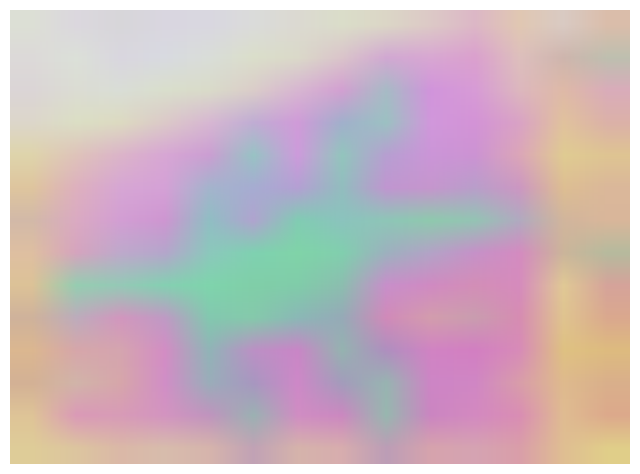

In [5]:


def get_patch_pca_rgb_vibrant(image_path, model, device, preprocessor,
                              register_count=4, layer=-1):
    """
    Compute a 3D PCA projection of patch embeddings for RGB visualization with vibrant colors.
    """
    # Load and preprocess image
    image = Image.open(image_path).convert("RGB")
    inputs = preprocessor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
    
    # hidden_states: tuple(num_layers) [batch, num_tokens, hidden_dim]
    hidden_states = outputs.hidden_states[layer][0]  # first (and only) batch

    # Tokens are ordered: [CLS], [registers], [patches]
    patch_embeddings = hidden_states[1+register_count:]  # [num_patches, hidden_dim]

    # PCA to 3D
    pca = PCA(n_components=3)
    patch_pca = pca.fit_transform(patch_embeddings.cpu().numpy())  # [num_patches, 3]

    # Normalize each channel to [0,1]
    patch_pca -= patch_pca.min(axis=0)
    patch_pca /= (patch_pca.max(axis=0) + 1e-8)

    # Reshape to spatial grid
    h = w = int(patch_pca.shape[0] ** 0.5)
    patch_pca_map = patch_pca.reshape(h, w, 3)

    return patch_pca_map, image

def visualize_patch_pca_rgb_vibrant(image, patch_pca_map, blur_sigma=1.0,
                                    alpha=0.5, color_multiplier=2.0):
    """
    Overlay a vibrant RGB PCA patch map on the original image.
    
    Args:
        blur_sigma: Gaussian smoothing sigma in patch units
        alpha: overlay transparency
        color_multiplier: factor to enhance vibrancy (passed through sigmoid)
    """
    # Smooth each channel
    for c in range(3):
        patch_pca_map[..., c] = gaussian_filter(patch_pca_map[..., c], sigma=blur_sigma)

    # Convert to tensor for PyTorch operations
    patch_tensor = torch.tensor(patch_pca_map, dtype=torch.float32)

    # Enhance vibrancy with multiplier and sigmoid
    vibrant_tensor = torch.sigmoid(patch_tensor * color_multiplier) 

    # Permute to HWC and convert to numpy for PIL
    vibrant_image = (vibrant_tensor.numpy() * 255).astype(np.uint8)

    # Upsample to image size
    vibrant_pil = Image.fromarray(vibrant_image).resize(image.size, resample=Image.BILINEAR)

    # Overlay
    plt.figure(figsize=(8,8))
    #plt.imshow(image, alpha=0.8)
    plt.imshow(vibrant_pil, alpha=alpha)
    plt.axis('off')
    #plt.show()
    plt.savefig("Visualisation_PCA_Feature_maps_diverse_marine.pdf",  dpi=500, bbox_inches="tight", transparent=False)


patch_pca_map, image = get_patch_pca_rgb_vibrant(image_path, model, device, preprocessor)
visualize_patch_pca_rgb_vibrant(image, patch_pca_map, blur_sigma=0.0, alpha=1.0, color_multiplier=2)


